## K-means clustering on the data

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pickle

In [11]:
from numpy import unique
from numpy import where
from matplotlib import pyplot
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans

In [3]:
import sys
import os
sys.path.append('../..')
from src.utils.directories import get_parent_directory

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [4]:
parent_dir = get_parent_directory()

In [63]:
all_pkl_path = (os.path.join(parent_dir, "data/processed/ml_ready/merged_all.pkl"))

with open(all_pkl_path, 'rb') as f:
    data = pickle.load(f)

### Variables needed for clustering
S, T, log_eps, log_N2, dTdz, dSdz

In [13]:
var_df = data [['S', 'T', 'log_eps', 'log_N2', 'dTdz', 'dSdz']]

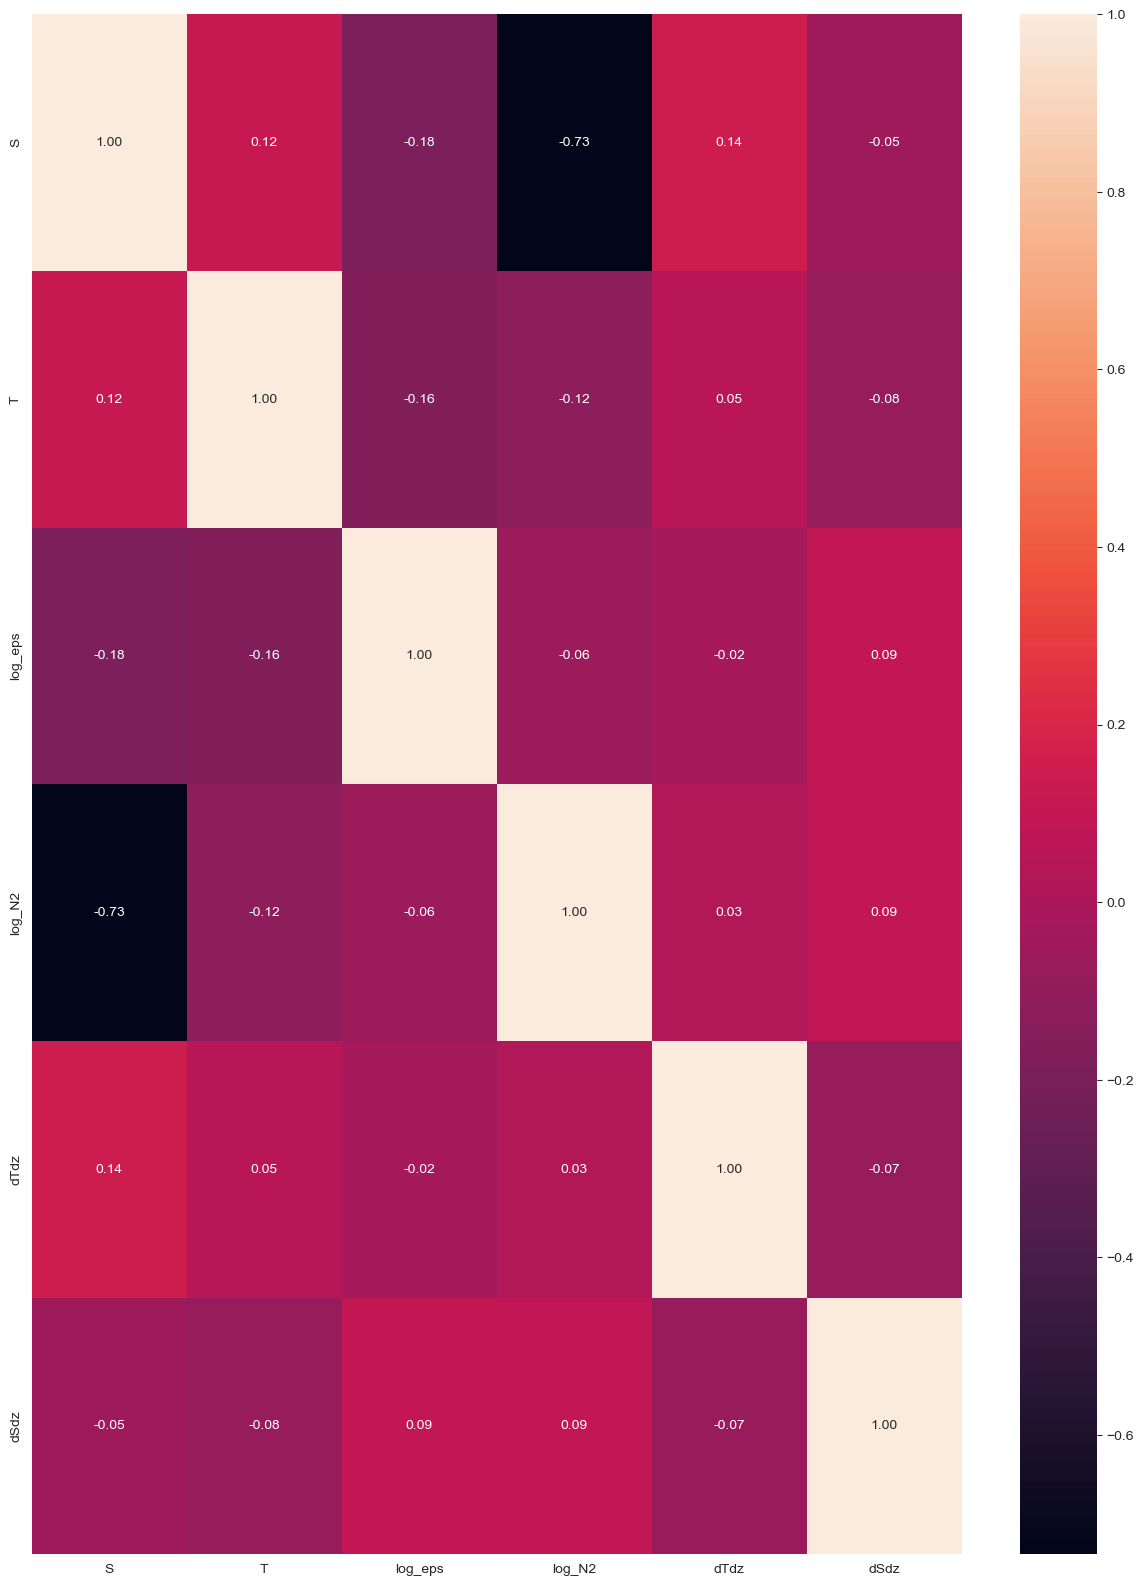

In [29]:
from pylab import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

def plot_correlation(data):
    rcParams['figure.figsize'] = 15, 20
    fig = plt.figure()
    sns.heatmap(data.corr(), annot=True, fmt=".2f")
    plt.show()

# plot correlation & densities
plot_correlation(var_df)

## Scaling

In [46]:
# Keep the column names
column_names = var_df.columns

X = var_df

# Normalize the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add the column names back to the X_scaled array
X_scaled = pd.DataFrame(X_scaled, columns=column_names)

## Outlier detection

In [48]:
# Detect and handle outliers using Z-score method
from scipy import stats
z_scores = np.abs(stats.zscore(X_scaled))
threshold = 3  # Adjust the threshold as needed
outlier_indices = np.where(z_scores > threshold)
X_cleaned = X_scaled[(z_scores < threshold).all(axis=1)]

## K nearest neighbours

In [76]:
X = X_cleaned

In [77]:
# Initialize the K-means clustering model
k = 5  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)

# Fit the K-means model to the data
kmeans.fit(X)

# Get cluster labels for each data point
cluster_labels = kmeans.labels_

## Elbow method: amount of clusters
look at within cluster variance

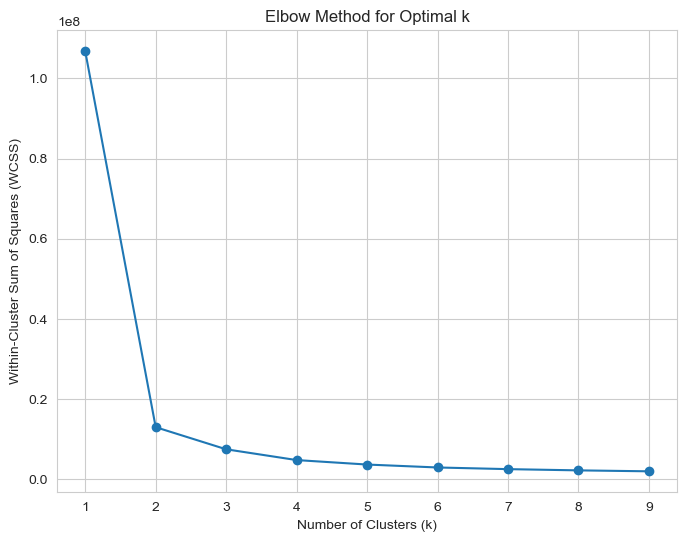

In [55]:
X = X_cleaned

# Initialize a list to store the within-cluster sum of squares (WCSS) values
wcss = []

# Specify a range of values for k (number of clusters)
k_values = range(1, 10)

# Calculate WCSS for different values of k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(var_df)
    wcss.append(kmeans.inertia_)

# Plot the elbow method curve
plt.figure(figsize=(8, 6))
plt.plot(k_values, wcss, marker='o', linestyle='-')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(k_values)
plt.grid(True)
plt.show()

## Plot clusters

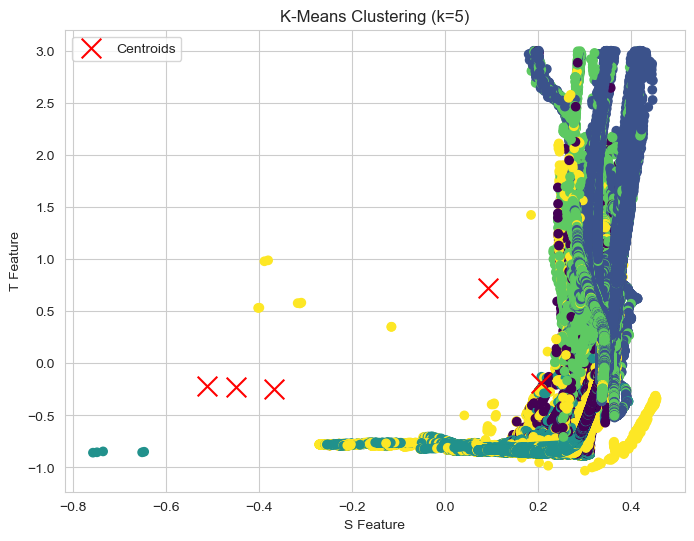

In [53]:
# Select the two features (S and T) for plotting
feature_s = X['S']
feature_t = X['T']

# Plot the data points with cluster assignments
plt.figure(figsize=(8, 6))
plt.scatter(feature_s, feature_t, c=cluster_labels, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 3], kmeans.cluster_centers_[:, 4], c='red', marker='x', s=200, label='Centroids')
plt.title(f'K-Means Clustering (k={k})')
plt.xlabel('S Feature')
plt.ylabel('T Feature')
plt.legend()
plt.show()

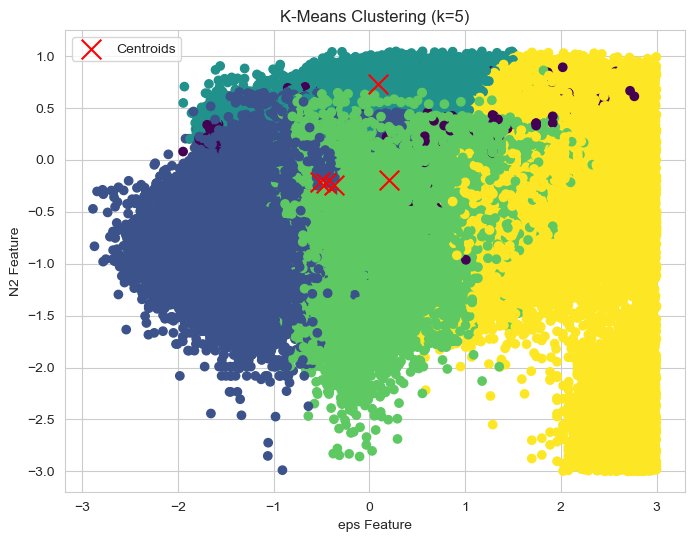

In [54]:
# Select the two features (S and T) for plotting
feature_e = X['log_eps']
feature_N = X['log_N2']

# Plot the data points with cluster assignments
plt.figure(figsize=(8, 6))
plt.scatter(feature_e, feature_N, c=cluster_labels, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 3], kmeans.cluster_centers_[:, 4], c='red', marker='x', s=200, label='Centroids')
plt.title(f'K-Means Clustering (k={k})')
plt.xlabel('eps Feature')
plt.ylabel('N2 Feature')
plt.legend()
plt.show()

## Spatial comparison

In [94]:
X_input = X[['S', 'T', 'log_eps', 'log_N2', 'dTdz', 'dSdz']]
# X_output = X[['Cluster']]

# Use the inverse_transform method to anti-scale X_scaled
transformed_df = pd.DataFrame(scaler.inverse_transform(X_input), columns=X_input.columns)
# Combine the inverse-transformed input features with the 'Cluster' column
# combined_df = transformed_df.assign(Cluster=X_output)
# Get cluster labels for each data point
# Add cluster labels to the DataFrame
transformed_df['Cluster'] = kmeans.labels_

In [95]:
transformed_df

,S,T,log_eps,log_N2,dTdz,dSdz,Cluster
0,34.200404,-1.885862,-6.298421,-6.575730,0.000049,-0.000295,0
1,34.216128,-1.881480,-6.425529,-5.763924,0.000082,0.000211,0
2,34.228100,-1.876567,-8.212019,-6.021717,-0.000010,0.000712,0
3,34.228828,-1.878046,-7.104307,-5.707662,0.000088,0.000174,0
4,34.247785,-1.891290,-6.638419,-5.532464,0.000259,0.000343,0
...,...,...,...,...,...,...,...
844569,34.706534,1.588848,-8.865618,-6.403454,0.000482,-0.000054,2
844570,34.706882,1.584602,-8.516571,-6.270092,0.000509,-0.000039,2
844571,34.707318,1.578658,-8.574194,-6.177027,0.000321,0.000019,2
844572,34.706502,1.578185,-8.492338,-6.140031,0.000007,0.000055,2


In [101]:
# Round the values in the DataFrames to a specific number of decimal places
decimals = 4  # Adjust as needed
data_rounded = data.round(decimals)
transformed_df_rounded = transformed_df.round(decimals)

# Merge based on multiple columns (A and B)
merged_df = transformed_df_rounded.merge(data_rounded, on=['S', 'T', 'log_eps', 'log_N2', 'dSdz', 'dTdz'], how='left')

In [103]:
merged_df.columns

Index(['S', 'T', 'log_eps', 'log_N2', 'dTdz', 'dSdz', 'Cluster', 'depth',
       'profile', 'cruise', 'latitude', 'longitude'],
      dtype='object')